This is all according to https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2025/01-intro/homework.md.

In [1]:
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Onehot encoding of pickup and drop location
from sklearn.feature_extraction import DictVectorizer

# Regression using LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

# Calculting the score of model
from sklearn.metrics import root_mean_squared_error 

# Save model
import pickle
%matplotlib inline

## Q1. Read the data for January. How many columns are there?

In [18]:
df_analysis = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
df_analysis.shape

(3066766, 19)

Ans: 19

In [8]:
df_analysis.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## Q2. What's the standard deviation trip duration in January?

In [19]:
df_analysis['duration'] = df_analysis["tpep_dropoff_datetime"] - df_analysis["tpep_pickup_datetime"]
df_analysis['duration'] = df_analysis["duration"].apply(lambda td: td.total_seconds() / 60)
df_analysis['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

Ans: 42.59

## Q3. What fraction of the records left after you dropped the outliers?

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [20]:
pre_count = df_analysis.shape[0]
df_analysis = df_analysis[(df_analysis["duration"] >= 1) & (df_analysis["duration"] <= 60)]
post_count = df_analysis.shape[0]
(post_count / pre_count) * 100.

98.1220282212598

Ans: 98.12%

## Q4. What's the dimensionality of this matrix (number of columns)?

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [28]:
categotical = ['PULocationID', 'DOLocationID']
df_analysis[categotical] = df_analysis[categotical].astype(str)

In [29]:
dv = DictVectorizer()
train_dicts = df_analysis[categotical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6018346 stored elements and shape (3009173, 515)>

Ans: 515

## Q5: What's the RMSE on train?

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

In [30]:
target = 'duration'
y_train = df_analysis[target].values
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.649261932106969

Ans: 7.65

## Q6: What's the RMSE on validation?

Now let's apply this model to the validation dataset (February 2023).

In [5]:
CATEGORICAL = ['PULocationID', 'DOLocationID']

def read_dataframe(file_link):
    df = pd.read_parquet(file_link)

    # convert duration from second to minute
    df['duration'] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    df['duration'] = df["duration"].apply(lambda td: td.total_seconds() / 60)

    # keep only the records where the duration was between 1 and 60 minutes (inclusive) and remove outliers
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    # For One Hot encoding, values must be passed as string to be converted into numerical
    df[CATEGORICAL] = df[categotical].astype(str)
    
    return df

In [3]:
# Training dataset   - JAN 2023
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")

# Validation dataset - FEB 2023
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")

In [4]:
# Compare length of both dataset
len(df_train), len(df_val)

(3009173, 2855951)

In [6]:
dv = DictVectorizer()

train_dicts = df_train[CATEGORICAL].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[CATEGORICAL].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811818743246608

Ans: 7.81

## Compare the distributions of both actual and prediction

/tmp/ipykernel_59199/3391228831.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label= 'Prediction')
/tmp/ipykernel_59199/3391228831.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label= 'Actual')


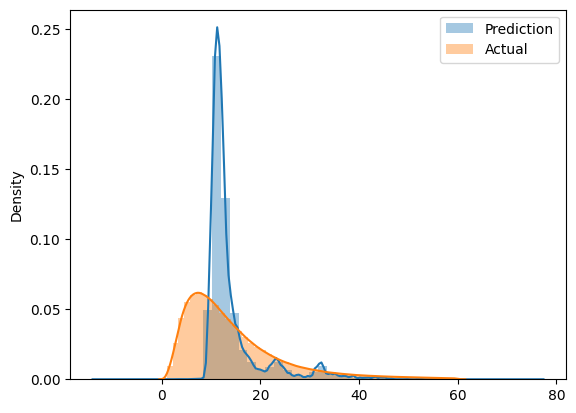

In [9]:
sns.distplot(y_pred, label= 'Prediction')
sns.distplot(y_train, label= 'Actual')
plt.legend()

## Observation

The Feb dataset has most values around the 8 min mark. <br>
However, our model predicts mostly around 10 mins and 20 mins which is approximately 14 min on average.

In [11]:
y_pred.sum()/len(y_pred)

14.114625577797515